In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

## Session 07

## Multiple Hidden Layers Two Class
<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Statement
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [3]:
###----------------------
### Some Basic Parameters
###----------------------

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

TEST_SIZE = 0.2 # Test size

EPOCHS = 20001 # number of cycles to run
ALPHA = 0.1 # learning rate
NUM_SAMPLE = 1280
NOISE = 0.2

<Figure size 1500x900 with 0 Axes>

## Generate Data Set
<p style="font-family: Arial; font-size:1.2em;color:black;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [4]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLE, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

In [5]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])
data_df['Target'] = y
#data_df.head()

#data_df.describe()

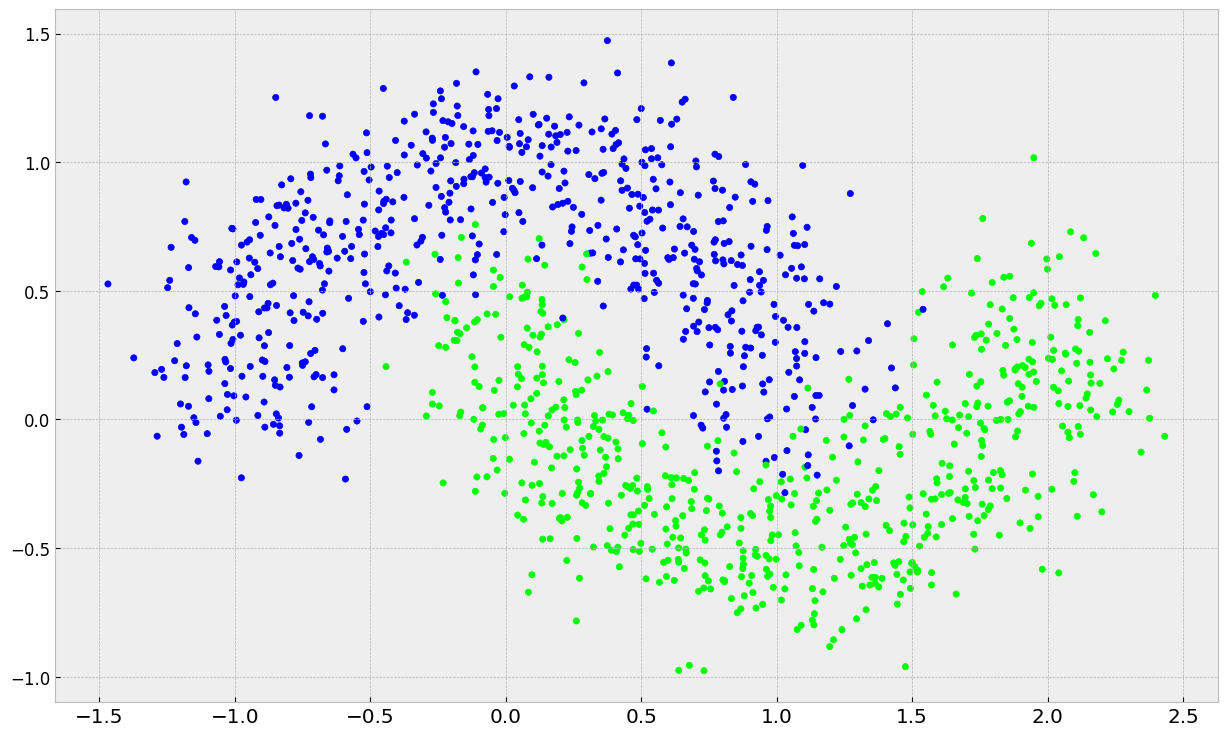

In [6]:
# Plot the data
plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=CMAP)

In [7]:
def fn_plot_decision_boundary(pred_func, X, y):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
       Return:
           None           
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1), cmap=CMAP, edgecolors='black')

In [8]:
y = pd.get_dummies(y).values
y

array([[False,  True],
       [ True, False],
       [False,  True],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [9]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024, 2) (256, 2) (256, 2)


# Neural Network

## Softmax
For Output layer

$
\begin{aligned}
z^{[2]} & = a^{[1]}. W^{[2]} + b^{[2]} \\
a^{[2]} & = \hat{y} = \mathrm{softmax}(z^{[2]})\\
\end{aligned}
$

<p style="font-family: Arial; font-size:1.2em;color:black;">
    Where:
</p>
$
\begin{aligned}
\mathrm{softmax}(z_i) & =  \frac{e^{z_i}}{\sum\limits_{i = 1}^{L} {e^{z_i}}}\\
\end{aligned}
$
    <p style="font-family: Arial; font-size:1.2em;color:black;">
    Taking instability of Softmax into account, it is recommended to tweak the formula a bit:<br><br>
        $\mathrm{softmax}(z_i) = \large{\frac{e^{z_i – max\left ( z \right )}}{\sum\limits_{i=1}^{L} e^{z_i}- max\left ( z \right )}}$
</p>
    </div>
    

## Softmax Function for output layer

In [ ]:
def fn_softmax(z):
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    
    exp_scores = np.exp( z - np.max(z) )

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

## Activation Function for other layers

In [ ]:
def fn_actv(z):
    '''
    Args:
        z: array
    Returns:
        z: array
    '''
    return np.tanh(z)

def fn_actv_prime(a):
    '''
    Args:
        a: array
    Returns:
        a: array
    '''
        
    return (1 - np.power(a, 2))

## Multiple hidden layers

<p style="font-family: Arial; font-size:1.2em;color:black;"> 
    Moving over to multilayer network. Our data has <strong>two</strong> features. Hence size of input layer will also be two. The output is binary, we can code it as single column as well as double column output. Let's consider following hidden layers:</p>
<table style="font-family: Arial; font-size:1.2em;color:black;">
    <tr>
        <th>#</th>
        <th>Layer Number</th>
        <th>Nodes </th>
        <th>Activation </th>
    </tr>
    <tr>
        <td>1</td>
        <td>Input Layer</td>
        <td>2</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>2</td>
        <td>Hidden Layer 1</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>3</td>
        <td>Hidden Layer 2</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>4</td>
        <td>Hidden Layer 3</td>
        <td>4</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>5</td>
        <td>Hidden Layer 4</td>
        <td>3</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>6</td>
        <td>Layer 5 (Output)</td>
        <td>2</td>
        <td>softmax</td>
    </tr>
</table>

<img src='../../images/dnn_nb_s06_fig3.png' style='width: 800px' alt = 'dnn_nb_s06_fig3.png'/>

## Loss Function

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the softmax output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log\hat{y_i} + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log\hat{y}_i + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

## Forward Propogation

<img src='../../images/dnn_nb_s06_fig4.png' style='width: 800px' alt = 'dnn_nb_s06_fig4.png'/>
<br>
                                                               
$
\begin{aligned}
z^{[l]} & = a^{[l-1]} . W^{[l]} + b^{[l]}\\
a^{[l]} & = \text{g}(z^{[l]})\text{ for hidden layers} \\
a^{[l]} & = \mathrm{softmax}(z^{[l]})\text{ for output layer}  \\
\end{aligned}
$

## Loss function

In [ ]:
def calculate_loss(model, X, y):
    
    # Extract Weights and biases from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    z1 = X.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)     # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation
    a2 = fn_actv(z2)     # Activation

    # Layer 3
    z3 = a2.dot(W3) + b3 # Aggregation
    a3 = fn_actv(z3)     # Activation

    # Layer 4
    z4 = a3.dot(W4) + b4 # Aggregation
    a4 = fn_actv(z4)     # Activation

    # Layer 5
    z5 = a4.dot(W5) + b5 # Aggregation
    a5 = fn_softmax(z5)  # softmax activation
    #***********************************
    
    # Calculating the loss
    data_loss = -(y * np.log(a5) + (1 - y) * np.log(1 - a5) ).sum() 

    return 1./num_examples * data_loss

## Predict Function
<p style="font-family: Arial; font-size:1.2em;color:black;">
For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propogation for supervised learning.
</p>

In [ ]:
def predict(model, X):
    # Extract Weights and biases from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    z1 = X.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)     # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation
    a2 = fn_actv(z2)     # Activation

    # Layer 3
    z3 = a2.dot(W3) + b3 # Aggregation
    a3 = fn_actv(z3)     # Activation

    # Layer 4
    z4 = a3.dot(W4) + b4 # Aggregation
    a4 = fn_actv(z4)     # Activation

    # Layer 5
    z5 = a4.dot(W5) + b5 # Aggregation
    a5 = fn_softmax(z5)  # softmax activation
    #***********************************
    
    return np.argmax(a5, axis = 1)

## Backpropogation
#### For last layer
$
\begin{aligned}
\partial{z^{[L]}}  & = a^{[L]} - y \\
\partial{W^{[L]}}  & = \frac{1}{m} a^{[L-1]T}\circ \partial{z^{[L]}} \\
\partial{b^{[L]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[L]}}, axis = 0, keepdims = True) \\
\end{aligned}
$

#### For any other layer
$
\begin{aligned}
\partial{a^{[l]}}  & = \partial{z^{[l+1]}} . \partial{W^{[l+1]T}}\\
\partial{z^{[l]}}  & = \partial{a^{[l]}} * ( 1-a^{[l]}**2)\\
\partial{W^{[l]}}  & = \frac{1}{m} a^{[l-1]T}\circ \partial{z^{[l]}} \\
\partial{b^{[l]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[l]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Build Model

In [ ]:
def build_model(param, X, y, alpha, epochs = 20000, print_loss = False):
    np.random.seed(RANDOM_STATE)
    
    W1 = np.random.randn(param['nn_hdim'][0], param['nn_hdim'][1]) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    
    W2 = np.random.randn(param['nn_hdim'][1], param['nn_hdim'][2]) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    
    W3 = np.random.randn(param['nn_hdim'][2], param['nn_hdim'][3]) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    
    W4 = np.random.randn(param['nn_hdim'][3], param['nn_hdim'][4]) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
   
    W5 = np.random.randn(param['nn_hdim'][4], nn_output_dim) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim))
    
    model ={}
    
    curr_loss = 0
    epoch, loss = [],[]
    
    for i in range(0, epochs):
        
        #### Forward ------------------------------
        # Layer 1
        z1 = X.dot(W1) + b1 
        a1 = fn_actv(z1)    # activation
        
        # Layer 2
        z2 = a1.dot(W2) + b2 
        a2 = fn_actv(z2)    # activation
        
        # Layer 3
        z3 = a2.dot(W3) + b3 
        a3 = fn_actv(z3)    # activation
        
        # Layer 4
        z4 = a3.dot(W4) + b4 
        a4 = fn_actv(z4)    # activation
        
        # Layer 5
        z5 = a4.dot(W5) + b5
        a5 = fn_softmax(z5) 

        
        ### Back Prop ------------------------------
        dz5 = a5- y
        
        # Layer 5
        dW5 = (a4.T).dot(dz5) 
        db5 = np.sum(dz5, axis=0, keepdims=True) # db5 is vertical sum of dz5
        da4 = dz5.dot(W5.T)
        
        #Layer 4
        dz4 = da4 * fn_actv_prime(a4)        
        dW4 = (a3.T).dot(dz4)        
        db4 = np.sum(dz4, axis=0, keepdims=True)
        da3 = dz4.dot(W4.T)
        
        #Layer 3
        dz3 = da3 * fn_actv_prime(a3)
        dW3 = (a2.T).dot(dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)
        da2 = dz3.dot(W3.T)
        
        #Layer 2
        dz2 = da2 * fn_actv_prime(a2)        
        dW2 = (a1.T).dot(dz2)        
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1= dz2.dot(W2.T)
        
        #Layer 1
        dz1 = da1 * fn_actv_prime(a1)
        dW1 = (X.T).dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)
        
        
        # Weights update
        W1 += -alpha * dW1 /num_examples
        b1 += -alpha * db1 /num_examples
        
        W2 += -alpha * dW2 /num_examples
        b2 += -alpha * db2 /num_examples
        
        W3 += -alpha * dW3 /num_examples
        b3 += -alpha * db3 /num_examples
        
        W4 += -alpha * dW4 /num_examples
        b4 += -alpha * db4 /num_examples
        
        W5 += -alpha * dW5 /num_examples
        b5 += -alpha * db5 /num_examples
        
        model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5}
        
        if i % 100 == 0:
            curr_loss = calculate_loss (model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
            
            
        # Print the loss.
        if print_loss and i % 1000 == 0:
            print(f"Loss after iteration {i:7d}: {curr_loss:.5f}" )
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    
    return model

In [ ]:
layer_param = {}
layer_param['nn_hdim'] = [X_train.shape[1],5,5,4,3]
loss_hist = {}

In [ ]:
num_examples = len(X_train)
alpha = ALPHA
epochs = EPOCHS
nn_output_dim = y_train.shape[1]
model = build_model(layer_param, X_train, y_train, alpha, epochs, print_loss = True) 

In [ ]:
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

In [ ]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis = 1), y_pred))

In [ ]:
print(classification_report(np.argmax(y_train, axis = 1), y_pred))

In [ ]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

In [ ]:
loss_df = pd.DataFrame(loss_hist)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5, edgecolor = 'b')

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)
loss = loss_df['loss'].values

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')


ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot

# place a text box in upper left in axes coords
ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")

ax.set_ylabel("Error")

ax.set_title('Last {} records'.format(l_range))

plt.tight_layout()